In [13]:
import os, sys
import logging
import matplotlib.pyplot as plt
from datetime import timedelta
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import warnings
warnings.filterwarnings('ignore')

PROJECT_PATH = "/Users/shawn/Documents/personal/rsi_divergence_detector"
sys.path.append(PROJECT_PATH)
# Load the training data
# Replace 'training_data.csv' with your actual data file or DataFrame
df = pd.read_pickle(f'{PROJECT_PATH}/data/processed_data/training_data.pickle')
divergence_data = pd.read_pickle(f"{PROJECT_PATH}/data/processed_data/divergence_data.pickle")

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')
logger = logging.getLogger(__name__)


In [14]:
def get_device():
    """
    Selects the best available device: MPS (Apple GPU), CUDA (NVIDIA GPU), or CPU.
    """
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS device for training.")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA device for training.")
    else:
        device = torch.device("cpu")
        print("Using CPU for training.")
    return device


In [15]:
# Test dataframes sliced
df_5m = df[df.timeframe == '5m']
df_5m_filter = df_5m.loc[df_5m.index > '2024-11-20 00:30:00']
# df_5m_filter = df_5m_filter.loc[df_5m_filter.index < '2024-11-22 20:00:00']

df_total = df_5m_filter
df_divergence = divergence_data['15m']


In [16]:
df_total.head(3)

,timestamp,open,high,low,close,volume,timeframe,rsi,macd,macd_signal,...,willr,cci,atr,return_1,return_5,return_10,volatility_5,volatility_10,volume_change,volume_rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2024-11-20 00:35:00,1732062900000,92080.35,92260.0,92050.53,92260.00,50.34613,5m,54.149277,9.696354,-7.417105,...,-37.900067,13.364110,194.759931,0.001951,0.000873,0.001121,0.001268,0.001520,-0.287841,58.752716
2024-11-20 00:40:00,1732063200000,92259.99,92320.0,92233.69,92233.70,69.42001,5m,53.172138,15.807042,-2.772276,...,-44.181714,87.280919,187.013507,-0.000285,0.001365,0.001378,0.001193,0.001510,0.378855,62.958378
2024-11-20 00:45:00,1732063500000,92233.69,92260.0,92124.51,92130.93,55.29224,5m,49.419335,12.216304,0.225440,...,-68.727907,-21.628155,183.333257,-0.001114,-0.000337,-0.001948,0.001317,0.001361,-0.203511,62.781558


In [17]:
df_divergence.head(3)

,end_datetime,entry_datetime,entry_price,previous_peak_datetime,divergence,price_change,rsi_change,TP,SL,label,...,SL_percent,position,TP_vs_SL,TP_/_SL,profit,div_5m,div_15m,div_1h,div_4h,div_1d
start_datetime,,,,,,,,,,,,,,,,,,,,,
2017-08-17 16:15:00,2017-08-17 18:00:00,2017-08-17 18:30:00,4287.69,2017-08-17 14:30:00,Bullish Divergence,5.18,6.47,4320.56,4218.68,False,...,1.61,False,0.476354,0.48,-69.01,False,True,False,False,False
2017-08-17 18:30:00,2017-08-18 01:15:00,2017-08-18 01:45:00,4231.61,2017-08-17 14:30:00,Bullish Divergence,37.98,10.29,4268.61,4134.61,True,...,2.29,False,0.381422,0.38,37.00,False,True,False,False,False
2017-08-17 18:30:00,2017-08-18 15:15:00,2017-08-18 15:45:00,4248.00,2017-08-17 14:30:00,Bullish Divergence,36.84,13.37,4314.89,4209.50,False,...,0.91,False,1.737402,1.74,-38.50,False,True,False,False,False


## Joining divergence data and price data

In [102]:
def create_divergence_sequence(df5, divergence_data):
    """
    Create a divergence feature sequence aligned with df5 timestamps for multiple timeframes.
    divergence_data: { '5m': ddf_5m, '1h': ddf_1h, ... }
    Each ddf_x: has divergence info with timestamps. For each timestamp in df5, 
    we check if there's a bullish divergence (1), bearish divergence (-1), else 0.
    
    This is just an example. You need to adapt it based on how you store divergence info.
    """
    # Initialize a dict of arrays, one per timeframe
    divergence_arrays = {}
    for tf, ddf in divergence_data.items():
        # Assume ddf indexed by datetime with a column 'divergence' that can be 'Bullish' or 'Bearish' or None
        # We'll create an array aligned with df5 index
        arr = np.zeros(len(df5), dtype=np.float32)
        # For each event in ddf, mark the corresponding timestamps
        # This is a simplistic approach: if end_datetime in ddf matches a df5 timestamp,
        # set arr[idx] = 1 for bullish, -1 for bearish.
        # You may need a more sophisticated approach depending on your data.
        for start_dt, event in ddf.iterrows():
            end_dt = event['end_datetime']
        
            for time_delta in range(0, int((end_dt - start_dt).total_seconds()) + 1, 5*60):
                t = start_dt + pd.Timedelta(seconds=time_delta)
                if t in df5.index:
                    idx = df5.index.get_loc(t)
                    if event['divergence'] == 'Bullish Divergence':
                        arr[idx] = 1
                    elif event['divergence'] == 'Bearish Divergence':
                        arr[idx] = -1
        
        divergence_arrays[tf] = arr
    
    # Combine into a single DataFrame (or array)
    # For simplicity, just stack them column-wise
    divergence_df = pd.DataFrame(index=df5.index)
    for tf, arr in divergence_arrays.items():
        df5[f"div_{tf}"] = arr
    
    return df5

In [103]:
import time
t = time.time()
df_revised = create_divergence_sequence(df_5m, divergence_data)
print(f"{time.time() - t} taken.")

81.59271025657654 taken.


/var/folders/ns/shg9ht0545sbbr41sk4q_zgr0000gn/T/ipykernel_44174/1955272509.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5[f"div_{tf}"] = arr


In [107]:
df_revised.div_5m.value_counts()

div_5m
 0.0    320334
-1.0    233313
 1.0    213451
Name: count, dtype: int64

## Train LSTM

In [18]:
from src.dataset.lstm_dataset import LSTMDivergenceDataset
from src.model.lstm_mixed import MixedLSTMModel
from src.training.train_lstm import train_model, evaluate_model, plot_results, model_naming


In [19]:
df = pd.read_pickle(os.path.join(PROJECT_PATH, 'data', 'processed_data', 'training_data.pickle'))
divergence_data = pd.read_pickle(os.path.join(PROJECT_PATH, 'data', 'processed_data', 'divergence_data.pickle'))

# Filter 5-minute timeframe data
# price_df = df[df['timeframe'] == '5m'].copy()
price_df = pd.read_pickle(f"{PROJECT_PATH}/data/training_data/price_df.pickle")
divergence_df = divergence_data['15m'].copy()  # Assuming '5m' key exists

# Split divergence_df into train/val/test
total_events = len(divergence_df)
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

train_count = int(total_events * train_ratio)
val_count = int(total_events * val_ratio)
test_count = total_events - train_count - val_count

divergence_df_train = df_divergence.iloc[:train_count]
divergence_df_val = df_divergence.iloc[train_count:train_count+val_count]
divergence_df_test = df_divergence.iloc[train_count+val_count:]


In [20]:

logger.info(f"Train events: {len(divergence_df_train)}, "
            f"Validation events: {len(divergence_df_val)}, "
            f"Test events: {len(divergence_df_test)}")

# Prepare divergence_data for multiple timeframes (if applicable)
# Assuming divergence_data contains multiple timeframes
# Example: divergence_data = {'5m': ddf_5m, '15m': ddf_15m, '1h': ddf_1h, ...}
# For simplicity, using only '5m' here
divergence_data_subset = {'15m': divergence_df_train}

# Initialize Dataset
logger.info("Initializing datasets...")
train_dataset = LSTMDivergenceDataset(divergence_df=divergence_df_train, 
                                        price_df=price_df, 
                                        divergence_data=divergence_data, 
                                        seq_length=288)  # 288 * 5min = 24 hours
# Use the same scaler for validation and test
scaler = train_dataset.scaler
val_dataset = LSTMDivergenceDataset(divergence_df=divergence_df_val, 
                                    price_df=price_df, 
                                    divergence_data=divergence_data, 
                                    seq_length=288, 
                                    scaler=scaler)

test_dataset = LSTMDivergenceDataset(divergence_df=divergence_df_test, 
                                    price_df=price_df, 
                                    divergence_data=divergence_data, 
                                    seq_length=288, 
                                    scaler=scaler)


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

2024-12-14 20:48:18,002 INFO Train events: 5812, Validation events: 1660, Test events: 831
2024-12-14 20:48:18,003 INFO Initializing datasets...


In [21]:

# Define device
device = get_device()
logger.info(f"Using device: {device}")

# Initialize Model
model_args = {
    "seq_input_dim": len(train_dataset.ts_cols),
    "seq_hidden_dim": 256,
    "seq_num_layers": 4,
    "nonseq_input_dim": len(train_dataset.nonseq_cols),
    "mlp_hidden_dim": 256,
    "num_classes": 2,
    "dropout": 0.3
}
model = MixedLSTMModel(**model_args)
logger.info(f"Model initialized with args: {model_args}")

# Generate model name
# Generate model name

lstm_model_name = model_naming(**model_args)
lstm_model_save_dir = os.path.join(PROJECT_PATH, 'model_data', 'mixed_lstm', lstm_model_name.split('.pt')[0])
os.makedirs(lstm_model_save_dir, exist_ok=True)
lstm_model_save_path = os.path.join(lstm_model_save_dir, lstm_model_name)


2024-12-14 20:48:25,764 INFO Using device: mps
2024-12-14 20:48:25,774 INFO Model initialized with args: {'seq_input_dim': 29, 'seq_hidden_dim': 256, 'seq_num_layers': 4, 'nonseq_input_dim': 6, 'mlp_hidden_dim': 256, 'num_classes': 2, 'dropout': 0.3}


Using MPS device for training.


In [22]:
# Train the model
import warnings
warnings.filterwarnings('ignore')

logger.info("Starting training...")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=500,
    lr=1e-3,
    device=device,
    log_interval=10,
    save_path=lstm_model_save_path
)


2024-12-14 20:48:29,726 INFO Starting training...
2024-12-14 20:48:58,512 INFO Epoch [1/500] - Train Loss: 6.9860, Train Acc: 0.6483 - Val Loss: 0.6278, Val Acc: 0.7036 - Time cost: 28.77
2024-12-14 20:48:58,534 INFO Best model saved with Val Acc: 0.7036
2024-12-14 20:49:26,982 INFO Epoch [2/500] - Train Loss: 0.7066, Train Acc: 0.7230 - Val Loss: 0.6107, Val Acc: 0.7036 - Time cost: 28.45
2024-12-14 20:49:55,440 INFO Epoch [3/500] - Train Loss: 0.6046, Train Acc: 0.7534 - Val Loss: 0.6091, Val Acc: 0.7036 - Time cost: 28.46
2024-12-14 20:50:24,206 INFO Epoch [4/500] - Train Loss: 0.5824, Train Acc: 0.7576 - Val Loss: 0.6071, Val Acc: 0.7036 - Time cost: 28.77
2024-12-14 20:50:52,827 INFO Epoch [5/500] - Train Loss: 0.5683, Train Acc: 0.7546 - Val Loss: 0.6086, Val Acc: 0.7036 - Time cost: 28.62
2024-12-14 20:51:21,836 INFO Epoch [6/500] - Train Loss: 0.5591, Train Acc: 0.7564 - Val Loss: 0.6081, Val Acc: 0.7036 - Time cost: 29.01
2024-12-14 20:51:50,350 INFO Epoch [7/500] - Train Loss

In [32]:
# Load the best Transformer model
logger.info("Loading the best Transformer model for testing...")
model.load_state_dict(torch.load(lstm_model_save_path, map_location=device))

# Evaluate the Transformer model on the test set
logger.info("Evaluating on test set...")
test_metrics = evaluate_model(model, test_loader, device)
logger.info(f"=================Test Metrics===================")
for key, value in test_metrics.items():
    if type(value) in [float]:
        logger.info(f"{key}: {value:4f}")
    else:
        logger.info(f"{key}: {value}")

metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'test_loss': test_metrics['loss'],
    'test_accuracy': test_metrics['accuracy'],
    'test_precision': test_metrics['precision'],
    'test_recall': test_metrics['recall'],
    'test_f1_score': test_metrics['f1_score'],
    'test_confusion_matrix': test_metrics['confusion_matrix']
}
metrics_path = os.path.join(lstm_model_save_dir, 'metrics.pkl')
pd.to_pickle(metrics, metrics_path)
logger.info(f"Metrics saved to {metrics_path}")

# Plot training and validation metrics
logger.info("Plotting training results for the Transformer model...")
plot_save_dir = os.path.join(lstm_model_save_dir, 'plots')
os.makedirs(plot_save_dir, exist_ok=True)
plot_results(train_losses, val_losses, train_accuracies, val_accuracies, outdir=plot_save_dir)

2024-12-14 21:27:09,013 INFO Loading the best Transformer model for testing...
2024-12-14 21:27:09,028 INFO Evaluating on test set...
2024-12-14 21:27:10,360 INFO =================Test Metrics===================
2024-12-14 21:27:10,360 INFO loss: 0.792221
2024-12-14 21:27:10,361 INFO accuracy: 0.742479
2024-12-14 21:27:10,361 INFO precision: 0.0
2024-12-14 21:27:10,361 INFO recall: 0.0
2024-12-14 21:27:10,362 INFO f1_score: 0.0
2024-12-14 21:27:10,362 INFO confusion_matrix: [[617   0]
 [214   0]]
2024-12-14 21:27:10,363 INFO Metrics saved to /Users/shawn/Documents/personal/rsi_divergence_detector/model_data/mixed_lstm/sid29_shd256_snl4_nid6_mhd256_nc2_d0.3000/metrics.pkl
2024-12-14 21:27:10,364 INFO Plotting training results for the Transformer model...


PermissionError: [Errno 1] Operation not permitted

## Train Transformer

In [16]:
from src.dataset.lstm_dataset import LSTMDivergenceDataset, create_divergence_sequence
from src.model.transformer import TransformerMixedModel
from src.training.train_lstm import train_model, evaluate_model, plot_results, model_naming
from sklearn.utils import class_weight
import numpy as np


In [17]:
df = pd.read_pickle(os.path.join(PROJECT_PATH, 'data', 'processed_data', 'training_data.pickle'))
divergence_data = pd.read_pickle(os.path.join(PROJECT_PATH, 'data', 'processed_data', 'divergence_data.pickle'))

# Filter 5-minute timeframe data
# price_df = df[df['timeframe'] == '5m'].copy()
price_df = pd.read_pickle(f"{PROJECT_PATH}/data/training_data/price_df.pickle")
divergence_df = divergence_data['15m'].copy()  # Assuming '5m' key exists

# Split divergence_df into train/val/test
total_events = len(divergence_df)
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

train_count = int(total_events * train_ratio)
val_count = int(total_events * val_ratio)
test_count = total_events - train_count - val_count

divergence_df_train = df_divergence.iloc[:train_count]
divergence_df_val = df_divergence.iloc[train_count:train_count+val_count]
divergence_df_test = df_divergence.iloc[train_count+val_count:]


logger.info(f"Train events: {len(divergence_df_train)}, "
            f"Validation events: {len(divergence_df_val)}, "
            f"Test events: {len(divergence_df_test)}")

# Prepare divergence_data for multiple timeframes (if applicable)
# Assuming divergence_data contains multiple timeframes
# Example: divergence_data = {'5m': ddf_5m, '15m': ddf_15m, '1h': ddf_1h, ...}
# For simplicity, using only '5m' here
divergence_data_subset = {'15m': divergence_df_train}

# Initialize Dataset
logger.info("Initializing datasets...")
train_dataset = LSTMDivergenceDataset(divergence_df=divergence_df_train, 
                                        price_df=price_df, 
                                        divergence_data=divergence_data, 
                                        seq_length=288)  # 288 * 5min = 24 hours
# Use the same scaler for validation and test
scaler = train_dataset.scaler
val_dataset = LSTMDivergenceDataset(divergence_df=divergence_df_val, 
                                    price_df=price_df, 
                                    divergence_data=divergence_data, 
                                    seq_length=288, 
                                    scaler=scaler)

test_dataset = LSTMDivergenceDataset(divergence_df=divergence_df_test, 
                                    price_df=price_df, 
                                    divergence_data=divergence_data, 
                                    seq_length=288, 
                                    scaler=scaler)


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

2024-12-14 20:20:07,995 INFO Train events: 5812, Validation events: 1660, Test events: 831
2024-12-14 20:20:07,995 INFO Initializing datasets...


In [8]:
device = get_device()
logger.info(f"Using device: {device}")

# Initialize Transformer Model
transformer_model_args = {
    "seq_input_dim": len(train_dataset.ts_cols),
    "seq_model_dim": 512,          # You can adjust this as needed
    "seq_num_heads": 8,            # Number of attention heads
    "seq_num_layers": 8,           # Number of Transformer layers
    "nonseq_input_dim": len(train_dataset.nonseq_cols),
    "mlp_hidden_dim": 256,
    "num_classes": 2,
    "dropout": 0.2,
    "max_len": 5000                 # Maximum sequence length
}


transformer_model = TransformerMixedModel(**transformer_model_args)
logger.info(f"Transformer Model initialized with args: {transformer_model_args}")

# Generate model name
transformer_model_name = model_naming(**transformer_model_args)
transformer_model_save_dir = os.path.join(PROJECT_PATH, 'model_data', 'transformer_mixed', transformer_model_name.split('.pt')[0])
os.makedirs(transformer_model_save_dir, exist_ok=True)
transformer_model_save_path = os.path.join(transformer_model_save_dir, transformer_model_name)

# Calculate class weights for imbalanced loss
classes = np.unique(divergence_df_train['label'])
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=divergence_df_train['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
logger.info(f"Class weights: {class_weights}")

2024-12-14 14:49:13,310 INFO Using device: mps
2024-12-14 14:49:13,353 INFO Transformer Model initialized with args: {'seq_input_dim': 29, 'seq_model_dim': 512, 'seq_num_heads': 8, 'seq_num_layers': 8, 'nonseq_input_dim': 6, 'mlp_hidden_dim': 512, 'num_classes': 2, 'dropout': 0.2, 'max_len': 5000}
2024-12-14 14:49:13,451 INFO Class weights: tensor([0.6570, 2.0922], device='mps:0')


Using MPS device for training.


In [9]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(transformer_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# Train the Transformer model
logger.info("Starting training of the Transformer model...")
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=transformer_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=500,
    lr=1e-3,
    device=device,
    log_interval=10,
    save_path=transformer_model_save_path,
    patience=50
)



2024-12-14 14:49:20,197 INFO Starting training of the Transformer model...
2024-12-14 14:51:22,909 INFO Epoch [1/500] - Train Loss: 52.3674, Train Acc: 0.4904 - Val Loss: 0.6750, Val Acc: 0.6127 - Time cost: 122.67
2024-12-14 14:51:23,201 INFO Best model saved with Val Acc: 0.6127
2024-12-14 14:53:24,617 INFO Epoch [2/500] - Train Loss: 1.9192, Train Acc: 0.4874 - Val Loss: 0.6343, Val Acc: 0.7036 - Time cost: 121.42
2024-12-14 14:53:24,782 INFO Best model saved with Val Acc: 0.7036
2024-12-14 14:55:23,606 INFO Epoch [3/500] - Train Loss: 1.5441, Train Acc: 0.4914 - Val Loss: 0.6540, Val Acc: 0.6825 - Time cost: 118.82
2024-12-14 14:57:21,011 INFO Epoch [4/500] - Train Loss: 1.3460, Train Acc: 0.4888 - Val Loss: 0.6571, Val Acc: 0.7036 - Time cost: 117.40
2024-12-14 14:59:18,098 INFO Epoch [5/500] - Train Loss: 1.1565, Train Acc: 0.5015 - Val Loss: 0.7594, Val Acc: 0.2964 - Time cost: 117.09
2024-12-14 15:01:15,094 INFO Epoch [6/500] - Train Loss: 1.1107, Train Acc: 0.5053 - Val Loss: 

2024-12-14 19:58:17,459 INFO Loading the best Transformer model for testing...
2024-12-14 19:58:25,340 INFO Evaluating on test set...
2024-12-14 19:58:30,586 INFO =================Test Metrics===================
2024-12-14 19:58:30,587 INFO loss: 0.873002
2024-12-14 19:58:30,587 INFO accuracy: 0.742479
2024-12-14 19:58:30,588 INFO precision: 0.0
2024-12-14 19:58:30,588 INFO recall: 0.0
2024-12-14 19:58:30,588 INFO f1_score: 0.0
2024-12-14 19:58:30,589 INFO confusion_matrix: [[617   0]
 [214   0]]
2024-12-14 19:58:30,592 INFO Metrics saved to /Users/shawn/Documents/personal/rsi_divergence_detector/model_data/transformer_mixed/sid29_smd512_snh8_snl8_nid6_mhd512_nc2_d0.2000_ml5000/metrics.pkl
2024-12-14 19:58:30,592 INFO Plotting training results for the Transformer model...


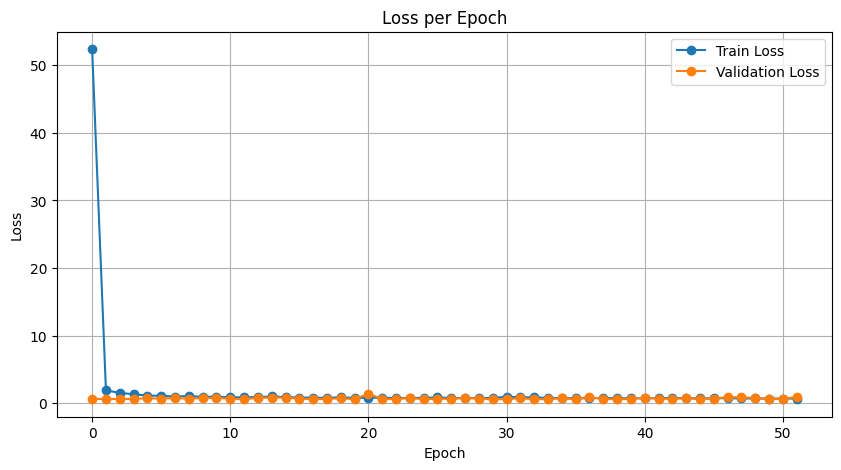

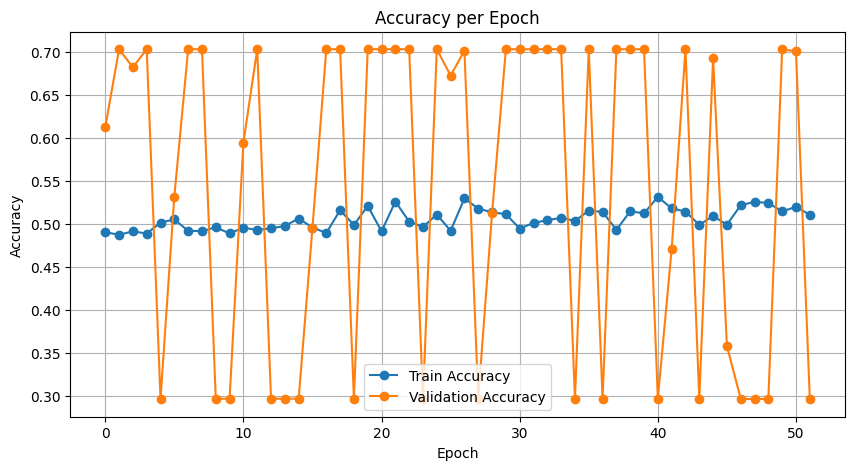

In [10]:

# Load the best Transformer model
logger.info("Loading the best Transformer model for testing...")
transformer_model.load_state_dict(torch.load(transformer_model_save_path, map_location=device))

# Evaluate the Transformer model on the test set
logger.info("Evaluating on test set...")
test_metrics = evaluate_model(transformer_model, test_loader, device)
logger.info(f"=================Test Metrics===================")
for key, value in test_metrics.items():
    if type(value) in [float]:
        logger.info(f"{key}: {value:4f}")
    else:
        logger.info(f"{key}: {value}")

metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'test_loss': test_metrics['loss'],
    'test_accuracy': test_metrics['accuracy'],
    'test_precision': test_metrics['precision'],
    'test_recall': test_metrics['recall'],
    'test_f1_score': test_metrics['f1_score'],
    'test_confusion_matrix': test_metrics['confusion_matrix']
}
metrics_path = os.path.join(transformer_model_save_dir, 'metrics.pkl')
pd.to_pickle(metrics, metrics_path)
logger.info(f"Metrics saved to {metrics_path}")

# Plot training and validation metrics
logger.info("Plotting training results for the Transformer model...")
plot_save_dir = os.path.join(transformer_model_save_dir, 'plots')
os.makedirs(plot_save_dir, exist_ok=True)
plot_results(train_losses, val_losses, train_accuracies, val_accuracies, outdir=plot_save_dir)